In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy
import scipy.stats

In [2]:
bins = numpy.linspace(0, 1, 101)

In [3]:
alpha, beta, p_nz = 4.220667439601125, 2.286973307856711, 0.13195574589578873

In [4]:
draws = scipy.stats.gamma.rvs(alpha, loc=0, scale=1/beta, size=100000)
draws[numpy.random.randint(0, len(draws), size=int(p_nz * len(draws)))] = 0

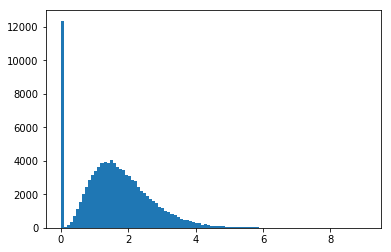

In [5]:
plt.hist(draws, bins=100);

In [6]:
p_values = list()
for draw in draws:
    if draw == 0:
        p=1
    else:
        p = p_nz * (1 - scipy.stats.gamma.cdf(draw, alpha, 0, 1/beta))
    p_values.append(p)

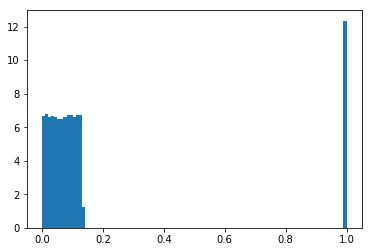

In [7]:
plt.hist(p_values, bins=bins, density=True);

## Compute actual values

In [8]:
import hetmech.hetmat
import hetmech.degree_weight
import hetmech.degree_group
import scipy.sparse
import tqdm

In [9]:
def matrix_to_dgp(matrix, dwpc_scaler, source_degree_to_ind, target_degree_to_ind):
    rows = dict()
    if scipy.sparse.issparse(matrix):
        matrix = matrix.toarray()
    
    for source_degree, row_inds in source_degree_to_ind.items():
        row_matrix = matrix[row_inds, :]
        for target_degree, col_inds in target_degree_to_ind.items():
            if source_degree == 0 or target_degree == 0:
                continue
            slice_matrix = row_matrix[:, col_inds]
            values = numpy.arcsinh(slice_matrix / dwpc_scaler)
            rows[(source_degree, target_degree)] = values.flatten().tolist()
    return rows

def metapath_to_full_dgp(hetmat, metapath):
#     _, _, pc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, dense_threshold=0.7, damping=0.0)
    _, _, dwpc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, dense_threshold=0.7, damping=0.5)
    scaler = dwpc_matrix.mean()

    source_degree_to_ind, target_degree_to_ind = hetmech.degree_group.metapath_to_degree_dicts(hetmat, metapath)
    
    perm_dgp = None
    for name, permat in tqdm.tqdm(hetmat.permutations.items()):
        _, _, matrix = hetmech.degree_weight.dwpc(permat, metapath, damping=0.5, dense_threshold=0.7)
        degree_to_dgp = matrix_to_dgp(matrix, scaler, source_degree_to_ind, target_degree_to_ind)
        if perm_dgp is None:
            perm_dgp = degree_to_dgp.copy()
        else:
            for degree_combo, dgp_list in perm_dgp.items():
                dgp_list.extend(degree_to_dgp[degree_combo])
    return perm_dgp

In [10]:
hetmat = hetmech.hetmat.HetMat('../../data/hetionet-v1.0.hetmat/')

In [11]:
metapath = 'DaGbC'

In [12]:
perm_dgp = metapath_to_full_dgp(hetmat, metapath)

100%|██████████| 200/200 [00:28<00:00,  7.11it/s]


In [13]:
p_values = list()
for values in tqdm.tqdm_notebook(list(perm_dgp.values())):
    # get the attributes of the null distribution for each
    values = numpy.array(values)
    values_nz = values[values > 0]
    var_nz = numpy.var(values_nz)
    mean_nz = numpy.mean(values_nz)
    theta = var_nz / mean_nz
    k = mean_nz / theta
    p_nz = len(values_nz) / len(values)
    
    # simulate observations
    draws = scipy.stats.gamma.rvs(k, loc=0, scale=theta, size=5)
    draws[numpy.random.randint(0, len(draws), size=round(p_nz * len(draws)))] = 0
    p_vals = list()
    for draw in draws:
        if draw == 0:
            p=1
        else:
            p = p_nz * (1 - scipy.stats.gamma.cdf(draw, k, 0, theta))
        p_vals.append(p)
    p_values.extend(p_vals)

/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in double_scalars


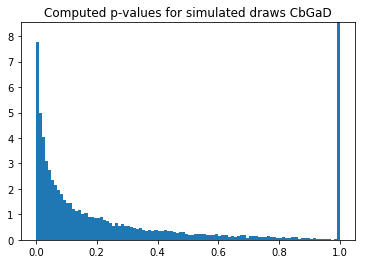

In [14]:
heights, bins, _ = plt.hist(p_values, bins=bins, density=True)
plt.ylim((0, 1.1 * max(heights[:-1])))
plt.title(f'Computed p-values for simulated draws {metapath}');